In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scipy.stats import norm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


df = pd.read_parquet("/Users/michaelbrady/Documents/repo/DU-VIRT-AI-PT-11-2024-U-LOLC/ny_ride_fair_optimization/mike_folder/final_model_data.parquet")
pd.set_option('display.max_columns', None)
df


,second_of_day,day_of_year,weekend,holiday,morning_rush,evening rush,prcp,temp,PUx,PUy,DOx,DOy,distance,durationsec,fare,tolls,airport,congestion,total,PU_Bronx,PU_Brooklyn,PU_Manhattan,PU_Queens,PU_Staten Island,DO_Bronx,DO_Brooklyn,DO_Manhattan,DO_Queens,DO_Staten Island,profit_per_hour,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,service_0,service_1,service_2
1,9,1,0,1,0,0,0.0,42.80,-8.220657e+06,4.992372e+06,-8.218525e+06,4.993771e+06,2.47,785.0,14.59,0.0,0.0,0.0,14.59,1,0,0,0,0,1,0,0,0,0,66.318182,False,False,False,False,True,False,False,False,False,False,True,False
2,33,1,0,1,0,0,0.0,42.80,-8.231953e+06,4.974857e+06,-8.232025e+06,4.972525e+06,2.02,474.0,20.62,0.0,0.0,0.0,20.62,0,0,0,1,0,0,1,0,0,0,158.615385,False,False,False,False,False,False,True,False,False,False,False,True
3,38,1,0,1,0,0,0.0,42.80,-8.212420e+06,4.977409e+06,-8.216190e+06,4.976140e+06,2.47,459.0,23.20,0.0,0.0,0.0,23.20,0,0,0,1,0,0,0,0,1,0,178.461538,False,False,True,False,False,False,False,False,False,False,False,True
5,42,1,0,1,0,0,0.0,42.80,-8.223575e+06,4.979119e+06,-8.231792e+06,4.962136e+06,11.32,1883.0,89.42,0.0,2.5,0.0,91.92,0,0,0,1,0,0,1,0,0,0,171.961538,False,False,False,False,False,True,False,False,False,False,False,True
6,51,1,0,1,0,0,0.0,42.80,-8.239432e+06,4.969960e+06,-8.238897e+06,4.961199e+06,5.21,705.0,39.18,3.5,0.0,5.5,48.18,0,0,1,0,0,0,1,0,0,0,195.900000,True,False,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6044440,85839,366,0,0,0,0,0.0,48.02,-8.233297e+06,4.959078e+06,-8.233297e+06,4.959078e+06,0.41,197.0,7.75,0.0,0.0,0.0,7.75,0,1,0,0,0,0,1,0,0,0,155.000000,False,False,False,True,False,False,False,False,False,False,True,False
6044441,85841,366,0,0,0,0,0.0,48.02,-8.225994e+06,4.963283e+06,-8.223930e+06,4.962458e+06,1.52,444.0,9.91,0.0,0.0,0.0,9.91,0,1,0,0,0,0,1,0,0,0,82.583333,False,False,False,True,False,False,False,False,False,False,False,True
6044442,85846,366,0,0,0,0,0.0,48.02,-8.217649e+06,4.988984e+06,-8.221850e+06,4.985513e+06,2.48,534.0,14.38,0.0,0.0,0.0,14.38,1,0,0,0,0,1,0,0,0,0,95.866667,False,False,False,False,True,False,False,False,False,False,False,True
6044443,85864,366,0,0,0,0,0.0,48.02,-8.234034e+06,4.964909e+06,-8.231941e+06,4.963280e+06,1.58,488.0,15.01,0.0,0.0,0.0,15.01,0,1,0,0,0,0,1,0,0,0,107.214286,False,False,False,True,False,False,False,False,False,False,False,True


Below is the prototype predictive engine. Find the input mid-cell to use any row as a sample input. (Later plan to have this dynamic with Nik's help.)

In [21]:
# bring in best models

with open("duration_model.pkl", "rb") as f:
    duration_model = pickle.load(f)

with open("earnings_model.pkl", "rb") as f:
    earnings_model = pickle.load(f)

duration_cols = duration_model.get_booster().feature_names
earnings_cols = earnings_model.get_booster().feature_names

# I needed help with this part, fixes the features to be used
# 

def fix_features_for_model(df_input, needed_cols):
    df_fixed = df_input.copy()
    drop_cols = [c for c in df_fixed.columns if c not in needed_cols]
    df_fixed.drop(columns=drop_cols, inplace=True, errors="ignore")
    for c in needed_cols:
        if c not in df_fixed.columns:
            df_fixed[c] = 0
    df_fixed = df_fixed[needed_cols]
    return df_fixed

# HERE IS THE INPUT
# INPUT ANY ROW # 1-4,090,595

row_index = 1799990
selected_row = df.iloc[row_index]

# features a (duration model)
duration_data = selected_row[[
    "second_of_day", "day_of_year", "PUx", "PUy", "DOx", "DOy", "distance", 
    "morning_rush", "evening rush", "prcp", "temp", "holiday", "weekend", 
    "airport", "congestion", "PU_Bronx", "PU_Brooklyn", "PU_Manhattan", 
    "PU_Queens", "PU_Staten Island", "DO_Bronx", "DO_Brooklyn", "DO_Manhattan", 
    "DO_Queens", "DO_Staten Island", "cluster_0", "cluster_1", "cluster_2", 
    "cluster_3", "cluster_4", "cluster_5", "cluster_6", "cluster_7", "cluster_8", 
    "service_1"
]].to_dict()

df_duration = pd.DataFrame([duration_data])
df_duration = fix_features_for_model(df_duration, duration_cols)
pred_duration_sec = duration_model.predict(df_duration)[0]
pred_duration_hrs = pred_duration_sec / 3600.0

# beginning to develop features b (earnings model)
# treating the dropoff as the new pickup
earnings_data = duration_data.copy()
earnings_data["PUx"] = earnings_data["DOx"]
earnings_data["PUy"] = earnings_data["DOy"]
# incomplete predictor set

df_earnings = pd.DataFrame([earnings_data])
df_earnings = fix_features_for_model(df_earnings, earnings_cols)
pred_earnings_hr = earnings_model.predict(df_earnings)[0]
adjusted_earnings_per_hour = pred_earnings_hr / (1 + pred_duration_hrs)

print(f"Predicted Transit to Pickup (Hours): {pred_duration_hrs:.2f}")
print(f"Predicted Earnings/Hour at Destination: ${pred_earnings_hr:.2f}")
print(f"Adjusted Earnings/Hour: ${adjusted_earnings_per_hour:.2f}")


Predicted Transit to Pickup (Hours): 0.19
Predicted Earnings/Hour at Destination: $87.31
Adjusted Earnings/Hour: $73.51


In [22]:
# establishing normalized distrubution

mu, sigma = df['profit_per_hour'].mean(), df['profit_per_hour'].std()

y_test = df['profit_per_hour'].values
y_hat = np.random.normal(mu, sigma, len(y_test))

mae = mean_absolute_error(y_test, y_hat)
mse = mean_squared_error(y_test, y_hat)
r2 = r2_score(y_test, y_hat)

print("Baseline Performance:")
print(f"MAE: {mae:.2f}")


Baseline Performance:
MAE: 32.99


In [23]:
df["profit_per_hour"].min()

1.0612244897959184

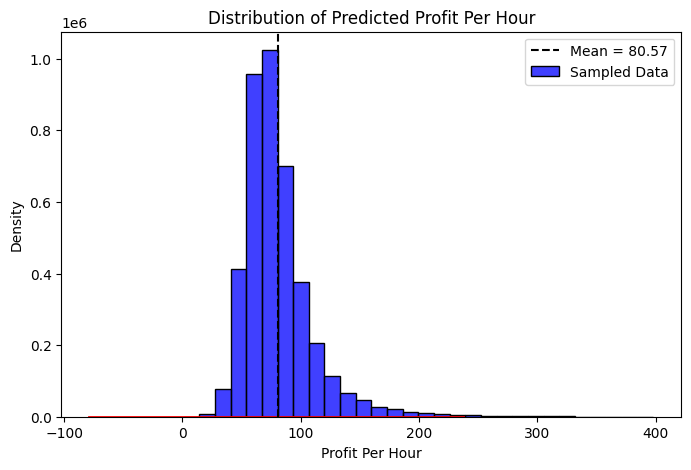

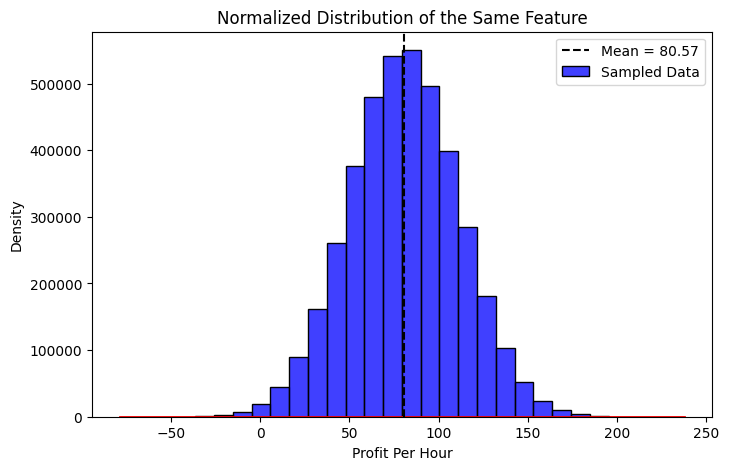

In [24]:
# show distributions of "profit_per_hour" target

x_values = np.linspace(min(y_hat), max(y_hat), 100)
y_values = norm.pdf(x_values, mu, sigma)


# plot the observed curve
plt.figure(figsize=(8, 5))
sns.histplot(df["profit_per_hour"], bins=30, color="blue", label="Sampled Data")
plt.plot(x_values, y_values, color="red", linewidth=2)
plt.axvline(mu, color="black", linestyle="--", label=f"Mean = {mu:.2f}")
plt.xlabel("Profit Per Hour")
plt.ylabel("Density")
plt.title("Distribution of Predicted Profit Per Hour")
plt.legend()
plt.show()

# plot the normalized curve
plt.figure(figsize=(8, 5))
sns.histplot(y_hat, bins=30, color="blue", label="Sampled Data")
plt.plot(x_values, y_values, color="red", linewidth=2)
plt.axvline(mu, color="black", linestyle="--", label=f"Mean = {mu:.2f}")
plt.xlabel("Profit Per Hour")
plt.ylabel("Density")
plt.title("Normalized Distribution of the Same Feature")
plt.legend()
plt.show()

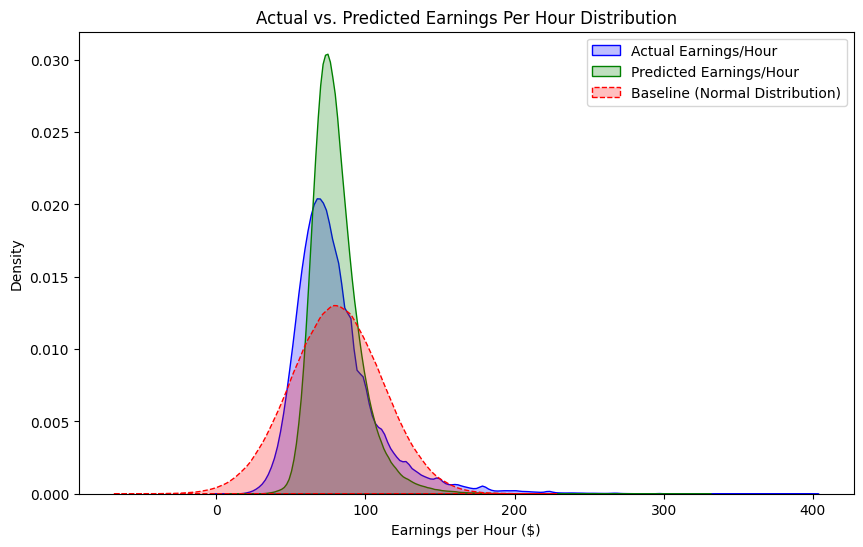

In [25]:

X = df[earnings_model.get_booster().feature_names] 
y = df["profit_per_hour"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# run the prediction
y_hat = earnings_model.predict(X_test)

plt.figure(figsize=(10, 6))

# actual distribution
sns.kdeplot(y_test, label="Actual Earnings/Hour", fill=True, color="blue")

# predicted distribution
sns.kdeplot(y_hat, label="Predicted Earnings/Hour", fill=True, color="green")

# normalized distribution
sns.kdeplot(np.random.normal(mu, sigma, len(y_test)), label="Baseline (Normal Distribution)", fill=True, linestyle="dashed", color="red")

plt.xlabel("Earnings per Hour ($)")
plt.ylabel("Density")
plt.title("Actual vs. Predicted Earnings Per Hour Distribution")
plt.legend()
plt.show()

